In [41]:
from data_parser import Butlr32_Data
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

In [42]:
path = "data\\standing_9_32x32_sensor.txt"
frames = 2000
fps = 5
data_obj = Butlr32_Data(path)
length = data_obj.get_length()
data = []

for i in range(frames):
    data.append(data_obj.pop_frame())

data = np.array(data)

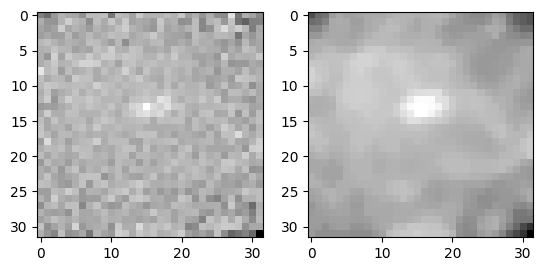

In [59]:
frame = data[4]

fig = plt.figure()
plt.gray() 
ax1 = fig.add_subplot(121) 
ax2 = fig.add_subplot(122)
ax1.imshow(frame)
new_frame = ndimage.gaussian_filter(frame, sigma=1)
new_frame = ndimage.median_filter(new_frame, size=3)
ax2.imshow(new_frame)


plt.show()

In [60]:
new_data = []
for i in range(len(data)):
    new_frame = ndimage.gaussian_filter(data[i], sigma=1)
    new_frame = ndimage.median_filter(new_frame, size=3)
    new_data.append(new_frame)

new_data

[array([[21.45407969, 21.68391416, 21.94714284, ..., 21.79848087,
         21.80912219, 21.80912219],
        [21.19529071, 21.55556402, 21.90556836, ..., 21.84474978,
         21.80912219, 21.7844406 ],
        [20.95649321, 21.45407969, 21.90556836, ..., 21.9332018 ,
         21.7844406 , 21.67176033],
        ...,
        [20.98094687, 21.26412232, 22.01639769, ..., 22.13132817,
         21.59128805, 21.26626914],
        [20.98094687, 21.54919247, 22.04919593, ..., 21.90213891,
         21.31888798, 20.69698897],
        [21.98800472, 22.04919593, 22.48616757, ..., 21.63137266,
         20.69698897, 20.06664758]]),
 array([[20.95451628, 21.0739265 , 21.4195118 , ..., 21.10216099,
         21.10216099, 21.71574212],
        [21.23498295, 21.4195118 , 21.76563904, ..., 21.1634139 ,
         21.54598617, 21.71574212],
        [21.43793551, 21.87048918, 22.06721696, ..., 21.54598617,
         21.6258321 , 21.6258321 ],
        ...,
        [20.91840629, 21.27248057, 21.7251033 , ..., 2